In [1]:
import os
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

In [2]:
asl_dataset_thresholded = '../data/raw/asl-dataset/'

asl_dataset_grayscaled = '../data/raw/asl-dataset-gray/'


In [3]:
def get_data(path):
    image_paths = []
    labels = []
    
    for label in os.listdir(path):
        label_path = os.path.join(path, label) + '/'
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)
                
    df = pd.DataFrame({"image_path": image_paths, "label": labels})
    return df

In [4]:
thresholded_df_path = get_data(asl_dataset_thresholded)

grayscaled_df_path = get_data(asl_dataset_grayscaled)

In [5]:
image_paths = thresholded_df_path["image_path"].values

first_img = cv2.imread(image_paths[625], cv2.IMREAD_GRAYSCALE)

first_img.shape

(128, 128)

In [6]:
def process_images(df, img_size=None):
    image_paths = df["image_path"].values
    labels = df["label"].values
    num_images = len(image_paths)

    if img_size is None:
        first_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
        height, width = first_img.shape
        vector_size = height * width
    else:
        vector_size = img_size * img_size

    image_data = np.zeros((num_images, vector_size), dtype=np.uint8)

    for i, path in tqdm(enumerate(image_paths), total=num_images, desc="Processing Images"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            if img_size is not None:
                img = cv2.resize(img, (img_size, img_size))
        
            image_data[i, :] = img.flatten()

    df_pixels = pd.DataFrame(image_data, columns=[f"p{i}" for i in range(vector_size)])

    df_pixels["label"] = labels

    le = LabelEncoder()
    df_pixels["encoded_label"] = le.fit_transform(labels)

    return df_pixels

In [7]:
# thresholded_df = process_images(thresholded_df_path)

grayscaled_df = process_images(grayscaled_df_path)

Processing Images:   0%|          | 0/26933 [00:00<?, ?it/s]

Processing Images: 100%|██████████| 26933/26933 [02:51<00:00, 157.44it/s]


In [8]:
grayscaled_df

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p16376,p16377,p16378,p16379,p16380,p16381,p16382,p16383,label,encoded_label
0,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
1,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
2,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
3,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
4,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26928,200,200,200,200,200,200,200,200,200,200,...,84,80,81,78,71,73,83,87,Y,23
26929,200,200,200,200,200,200,200,200,200,200,...,86,80,81,79,74,72,83,87,Y,23
26930,200,200,200,200,200,200,200,200,200,200,...,88,81,78,79,78,72,81,88,Y,23
26931,200,200,200,200,200,200,200,200,200,200,...,89,83,82,79,77,71,78,86,Y,23


In [9]:
print("\nPhân bố nhãn:")
label_counts = grayscaled_df['label'].value_counts()
print(label_counts)



Phân bố nhãn:
label
D    1579
E    1421
F    1247
N    1235
T    1185
B    1159
C    1153
K    1143
X    1134
S    1132
Y    1130
U    1108
G    1096
M    1082
Q    1078
I    1069
L    1047
V    1026
A    1023
H    1022
R    1021
W    1008
P     931
O     904
Name: count, dtype: int64


**Image size 64**

In [10]:
thresholded_size64 = process_images(thresholded_df_path, img_size=64)

grayscaled_size64 = process_images(grayscaled_df_path, img_size=64)

Processing Images: 100%|██████████| 26933/26933 [05:01<00:00, 89.34it/s] 


In [11]:
scaler = StandardScaler()

numeric_columns = thresholded_size64.columns[:-2]  
thresholded_numeric = thresholded_size64[numeric_columns]

thresholded_scaler = pd.DataFrame(
    scaler.fit_transform(thresholded_numeric),
    columns=numeric_columns
)

thresholded_scaler['label'] = thresholded_size64['label']
thresholded_scaler['encoded_label'] = thresholded_size64['encoded_label']

grayscaled_numeric = grayscaled_size64[numeric_columns]
grayscaled_scaler = pd.DataFrame(
    scaler.fit_transform(grayscaled_numeric),
    columns=numeric_columns
)

grayscaled_scaler['label'] = grayscaled_size64['label']
grayscaled_scaler['encoded_label'] = grayscaled_size64['encoded_label']

In [12]:
grayscaled_scaler

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p4088,p4089,p4090,p4091,p4092,p4093,p4094,p4095,label,encoded_label
0,1.553839,1.557853,1.559394,1.560493,1.563832,1.560802,1.559763,1.565265,1.568459,1.573655,...,2.698224,2.695670,2.706416,2.721045,2.739339,2.765774,2.789280,2.816669,A,0
1,1.553839,1.557853,1.559394,1.560493,1.563832,1.560802,1.559763,1.565265,1.568459,1.573655,...,2.698224,2.695670,2.706416,2.721045,2.739339,2.765774,2.789280,2.816669,A,0
2,1.553839,1.557853,1.559394,1.560493,1.563832,1.560802,1.559763,1.565265,1.568459,1.573655,...,2.698224,2.695670,2.706416,2.721045,2.739339,2.765774,2.789280,2.816669,A,0
3,1.553839,1.557853,1.559394,1.560493,1.563832,1.560802,1.559763,1.565265,1.568459,1.573655,...,2.698224,2.695670,2.706416,2.721045,2.739339,2.765774,2.789280,2.816669,A,0
4,1.553839,1.557853,1.559394,1.560493,1.563832,1.560802,1.559763,1.565265,1.568459,1.573655,...,2.698224,2.695670,2.706416,2.721045,2.739339,2.765774,2.789280,2.816669,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26928,0.912968,0.914681,0.916674,0.917020,0.918288,0.917373,0.916130,0.918666,0.920899,0.924196,...,0.056089,-0.041988,-0.038541,0.046507,-0.028265,-0.031611,-0.163626,0.060579,Y,23
26929,0.912968,0.914681,0.916674,0.917020,0.918288,0.917373,0.916130,0.918666,0.920899,0.924196,...,0.040268,-0.010339,-0.070275,0.030587,-0.012268,-0.031611,-0.147490,0.076791,Y,23
26930,0.912968,0.914681,0.916674,0.917020,0.918288,0.917373,0.916130,0.918666,0.920899,0.924196,...,0.040268,0.005485,-0.070275,-0.001253,0.019728,-0.047688,-0.115218,0.060579,Y,23
26931,0.912968,0.914681,0.916674,0.917020,0.918288,0.917373,0.916130,0.918666,0.920899,0.924196,...,0.056089,0.021310,-0.038541,-0.033092,0.035726,-0.015534,-0.115218,0.028154,Y,23


In [13]:
pca = PCA(0.95)

X_pca = pca.fit_transform(grayscaled_scaler[numeric_columns])
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca['label'] = grayscaled_scaler['label']
df_pca['encoded_label'] = grayscaled_scaler['encoded_label']


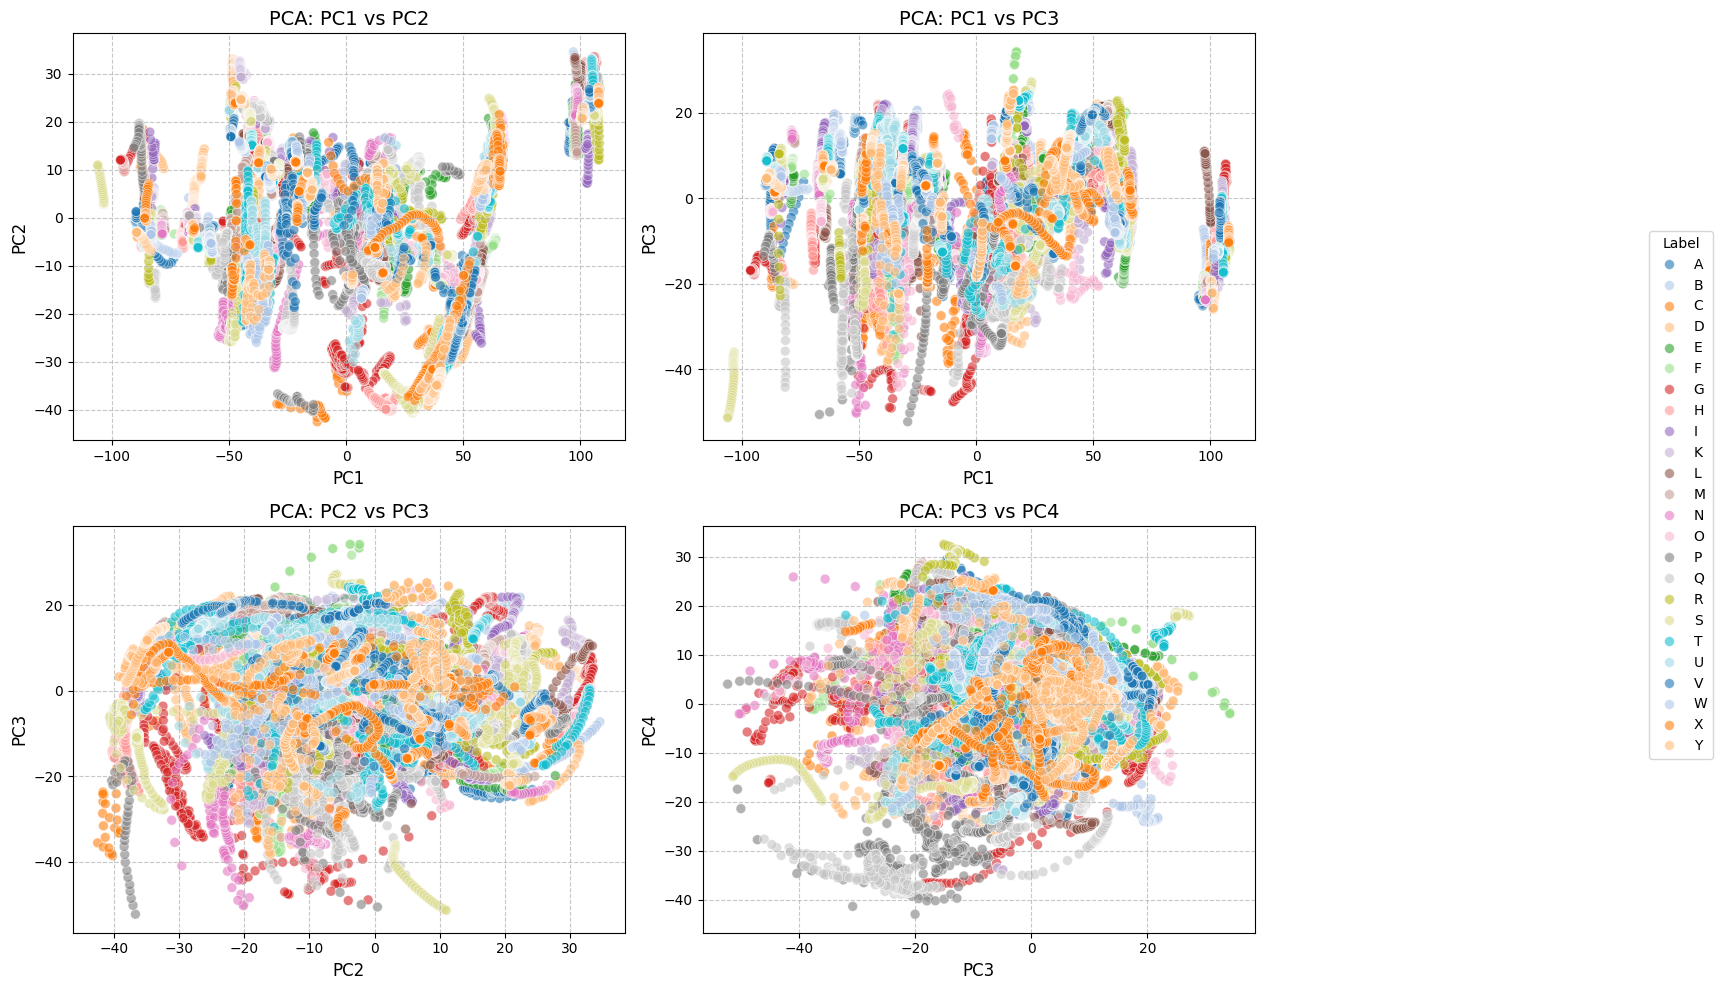

In [ ]:
plt.figure(figsize=(15, 10))

pairs = [(0, 1), (0, 2), (1, 2), (2, 3)]  

handles, labels = None, None

for i, (comp1, comp2) in enumerate(pairs):
    plt.subplot(2, 2, i+1)
    scatter = sns.scatterplot(
        x=df_pca[f"PC{comp1+1}"], 
        y=df_pca[f"PC{comp2+1}"], 
        hue=df_pca['label'], 
        palette="tab20",  
        alpha=0.6,        
        s=50,             
        edgecolor='white',
        linewidth=0.5,
        legend='full' if i == len(pairs)-1 else False  
    )
    plt.title(f"PCA: PC{comp1+1} vs PC{comp2+1}", fontsize=14)
    plt.xlabel(f"PC{comp1+1}", fontsize=12)
    plt.ylabel(f"PC{comp2+1}", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7) 

    if i == len(pairs)-1:
        handles, labels = scatter.get_legend_handles_labels()
        scatter.get_legend().remove() 

plt.figlegend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), title='Label', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()

Phương sai giữ lại với 4 PC: 0.747321113931624
Phương sai giữ lại với 6 PC: 0.7805076259014029


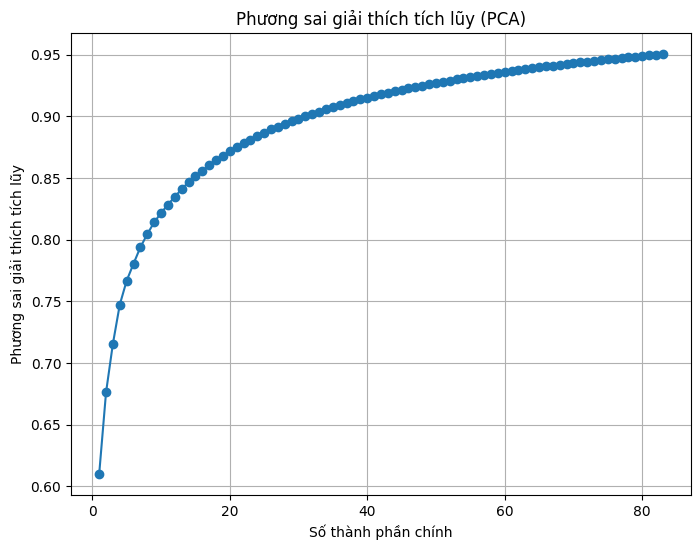

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Phương sai giữ lại với 4 PC:", sum(explained_variance_ratio[:4]))
print("Phương sai giữ lại với 6 PC:", sum(explained_variance_ratio[:6]))

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Số thành phần chính")
plt.ylabel("Phương sai giải thích tích lũy")
plt.title("Phương sai giải thích tích lũy (PCA)")
plt.grid(True)
plt.show()

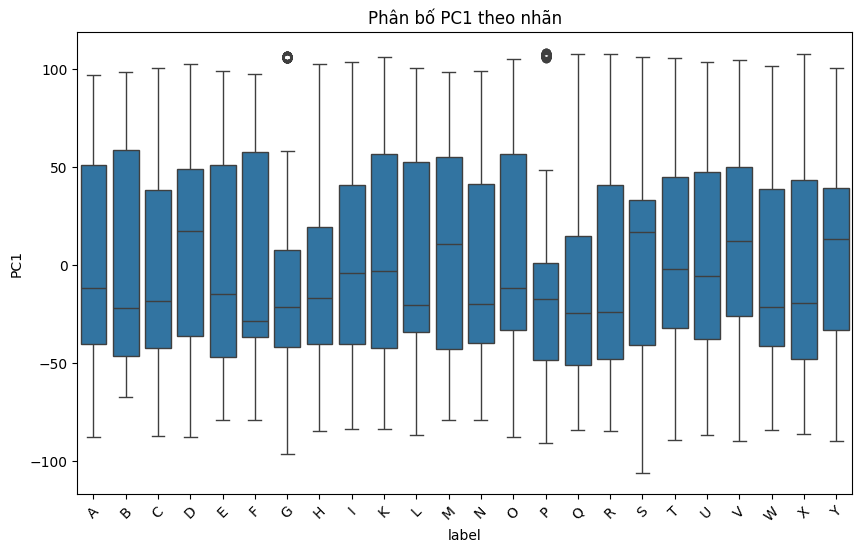

Tương quan giữa 6 PC đầu và nhãn:
PC1    0.001650
PC2   -0.029747
PC3    0.003770
PC4   -0.017794
PC5   -0.150739
PC6    0.105666
Name: encoded_label, dtype: float64


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='PC1', data=df_pca)
plt.title("Phân bố PC1 theo nhãn")
plt.xticks(rotation=45)
plt.show()

corr = df_pca[[f"PC{i+1}" for i in range(6)] + ['encoded_label']].corr()
print("Tương quan giữa 6 PC đầu và nhãn:")
print(corr['encoded_label'][:-1])

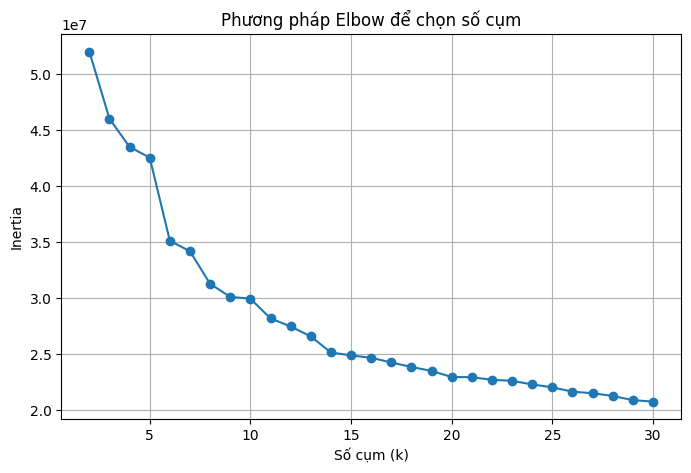

Silhouette Score (độ gắn kết và tách biệt của cụm): 0.1533
Adjusted Rand Index (ARI) giữa cụm và nhãn: 0.0571
Normalized Mutual Information (NMI) giữa cụm và nhãn: 0.2199


C:\Users\MY PC\AppData\Local\Temp\ipykernel_13768\3665199229.py:57: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
C:\Users\MY PC\AppData\Local\Temp\ipykernel_13768\3665199229.py:57: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
C:\Users\MY PC\AppData\Local\Temp\ipykernel_13768\3665199229.py:57: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
C:\Users\MY PC\AppData\Local\Temp\ipykernel_13768\3665199229.py:57: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('4').  Matplotlib is ignor

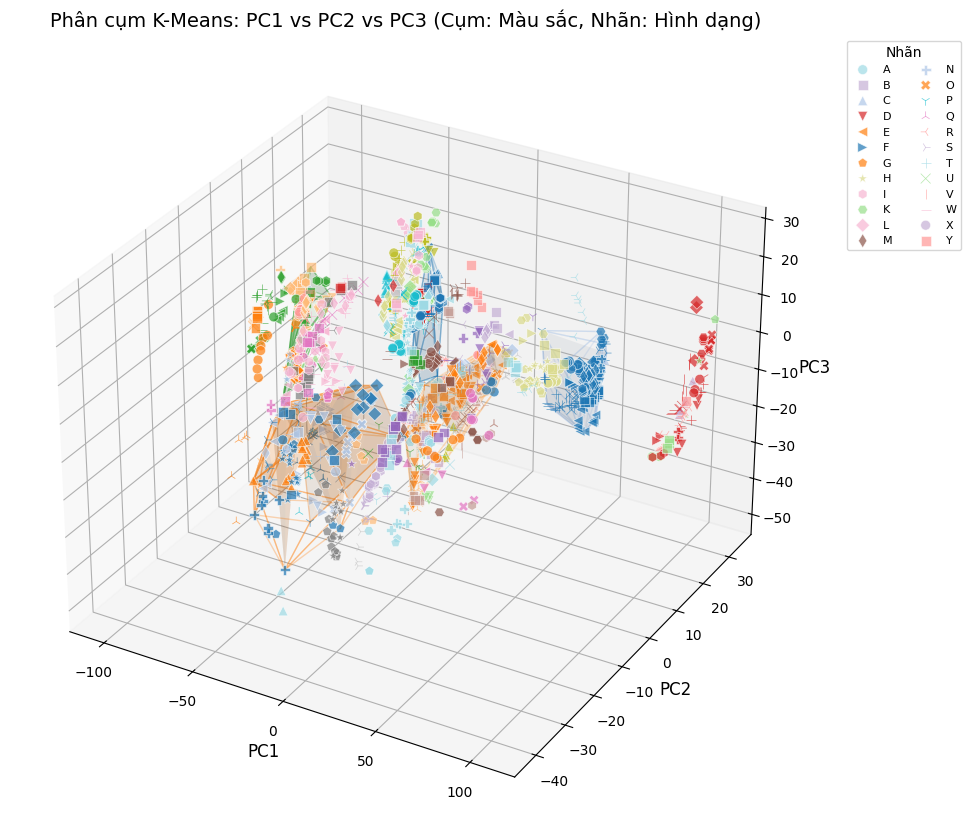


Bảng tần suất giữa cụm và nhãn:
label      A    B    C    D    E    F    G    H    I    K  ...    P    Q    R  \
cluster                                                    ...                  
0          0  171  140   40    9  194    0    0  131    0  ...   10    0    5   
1          0  148  159  148  151  148    0    0  157  153  ...   11    0    4   
2         62   20  137  104   41  209   75  151   11   29  ...   64  234  111   
3        106   50  154  480  340    0    0    0    9   82  ...    0    0    0   
4         63  100   96   96   91   95    0   79   75   84  ...    5    1    0   
5         61   52   54   51   56   54  153   49   47   51  ...   74   57   71   
6         10    0    0   27    0    0   44    0    0    0  ...  213  199    0   
7          0    0    0  181    0    0   76    0    0  309  ...    0    0  131   
8         52   61   51   54   56   54   55   51   54   61  ...   40   42   71   
9          0    0    0    0    0    0    0    0    0    0  ...   14   25    

In [ ]:
X_kmeans = df_pca.drop(columns=['label', 'encoded_label']).values

inertia = []
K_range = range(2, 31)  
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kmeans)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.title('Phương pháp Elbow để chọn số cụm')
plt.grid(True)
plt.show()

k_optimal = 24
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(X_kmeans)

df_pca['cluster'] = cluster_labels

silhouette_avg = silhouette_score(X_kmeans, cluster_labels)
print(f"Silhouette Score (độ gắn kết và tách biệt của cụm): {silhouette_avg:.4f}")

ari_score = adjusted_rand_score(df_pca['encoded_label'], cluster_labels)
nmi_score = normalized_mutual_info_score(df_pca['encoded_label'], cluster_labels)
print(f"Adjusted Rand Index (ARI) giữa cụm và nhãn: {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI) giữa cụm và nhãn: {nmi_score:.4f}")

np.random.seed(42)
sample_indices = np.random.choice(len(df_pca), 2000, replace=False)
df_sample = df_pca.iloc[sample_indices]

markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd', 
           'P', 'X', '1', '2', '3', '4', '+', 'x', '|', '_', 'o', 's', '^', 'v']
unique_labels = sorted(df_pca['label'].unique())  

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for label, marker in zip(unique_labels, markers):
    mask = df_sample['label'] == label
    ax.scatter(
        df_sample[mask]['PC1'], 
        df_sample[mask]['PC2'], 
        df_sample[mask]['PC3'],
        c=df_sample[mask]['cluster'], 
        cmap='tab20', 
        s=50, 
        alpha=0.7, 
        edgecolor='white',
        linewidth=0.5, 
        marker=marker, 
        label=label
    )

selected_clusters = [0, 1, 2, 3, 4]
colors = sns.color_palette("tab20", n_colors=k_optimal)  
for cluster in selected_clusters:
    mask = df_sample['cluster'] == cluster
    points = df_sample[mask][['PC1', 'PC2', 'PC3']].values
    if len(points) >= 4:  
        try:
            hull = ConvexHull(points)
            
            for simplex in hull.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 
                        color=colors[cluster], alpha=0.3, linewidth=1)
            
            ax.plot_trisurf(points[hull.vertices, 0], points[hull.vertices, 1], points[hull.vertices, 2],
                            color=colors[cluster], alpha=0.1)
        except:
            print(f"Không thể tạo bao lồi cho cụm {cluster} do số điểm không đủ hoặc dữ liệu không phù hợp.")

ax.set_title("Phân cụm K-Means: PC1 vs PC2 vs PC3 (Cụm: Màu sắc, Nhãn: Hình dạng)", fontsize=14)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)
ax.grid(True)

ax.legend(title='Nhãn', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, ncol=2)

plt.tight_layout(rect=[0, 0, 0.75, 1])  
plt.show()

cluster_label_crosstab = pd.crosstab(df_pca['cluster'], df_pca['label'])
print("\nBảng tần suất giữa cụm và nhãn:")
print(cluster_label_crosstab)

In [19]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC77,PC78,PC79,PC80,PC81,PC82,PC83,label,encoded_label,cluster
0,96.503992,24.188073,-23.148760,6.674455,-4.474705,-6.474405,2.961791,10.978677,-4.499586,7.683406,...,-1.008586,-0.100439,-0.940695,-0.266397,-1.124753,0.866169,0.580193,A,0,8
1,96.662305,23.476805,-23.660964,7.206289,-4.187087,-5.762798,2.674734,10.022770,-4.428510,7.526646,...,-0.866251,-0.009197,-1.359460,-0.370919,-0.906220,0.709240,0.641172,A,0,8
2,96.849728,22.983745,-23.816838,7.328293,-3.948929,-5.059278,2.609939,9.169886,-4.383136,7.477261,...,-0.683722,0.008180,-1.503957,-0.453778,-0.710632,0.518060,0.706849,A,0,8
3,96.849753,22.523615,-24.279601,7.483437,-3.753943,-4.556678,2.517802,8.578503,-4.373749,7.418167,...,-0.552081,0.062968,-1.666936,-0.521117,-0.517157,0.344892,0.794149,A,0,8
4,96.928709,21.964923,-24.352377,8.134817,-3.522388,-4.000110,2.361141,8.192019,-4.213790,7.342329,...,-0.412283,0.165029,-1.937748,-0.528677,-0.414020,0.127168,0.889021,A,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26928,59.851124,10.849295,1.500521,-1.799557,-9.651170,-1.308304,4.608244,-4.008570,1.188654,-9.166324,...,2.228242,0.144446,-0.774988,-0.290780,-0.790050,0.189556,-0.666330,Y,23,20
26929,59.759017,10.597024,1.278470,-1.186084,-9.901309,-1.723937,4.768914,-4.074853,0.917397,-9.134811,...,2.064886,-0.074681,-0.557807,-0.748856,-0.937735,0.478680,-0.618993,Y,23,20
26930,59.756218,10.369763,1.045541,-0.646588,-10.081144,-1.936328,4.882742,-4.124118,0.768494,-9.167183,...,1.720121,-0.295999,-0.436028,-1.194587,-1.039244,0.589065,-0.607932,Y,23,20
26931,59.696901,10.168216,0.794301,-0.082429,-10.318862,-2.158106,5.010216,-4.137313,0.532425,-9.025798,...,1.362346,-0.512724,-0.391641,-1.556587,-1.064101,0.562275,-0.497511,Y,23,20


In [20]:
grayscaled_df

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p16376,p16377,p16378,p16379,p16380,p16381,p16382,p16383,label,encoded_label
0,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
1,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
2,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
3,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
4,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26928,200,200,200,200,200,200,200,200,200,200,...,84,80,81,78,71,73,83,87,Y,23
26929,200,200,200,200,200,200,200,200,200,200,...,86,80,81,79,74,72,83,87,Y,23
26930,200,200,200,200,200,200,200,200,200,200,...,88,81,78,79,78,72,81,88,Y,23
26931,200,200,200,200,200,200,200,200,200,200,...,89,83,82,79,77,71,78,86,Y,23


In [21]:
numeric_columns_root = grayscaled_df.columns[:-2]  
grayscaled_numeric_root = grayscaled_df[numeric_columns_root]

grayscaled_scaler_root = pd.DataFrame(
    scaler.fit_transform(grayscaled_numeric_root),
    columns=numeric_columns_root
)

grayscaled_scaler_root['label'] = grayscaled_df['label']
grayscaled_scaler_root['encoded_label'] = grayscaled_df['encoded_label']


In [22]:
grayscaled_scaler_root.to_pickle("../data/processed/grayscaled_scaler_root.pkl")

df_pca.to_pickle("../data/processed/df_pca.pkl")


In [ ]:
X = grayscaled_scaler_root.drop(columns=['label', 'encoded_label'])
y = grayscaled_scaler_root['encoded_label']

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p16376,p16377,p16378,p16379,p16380,p16381,p16382,p16383,label,encoded_label
0,1.550441,1.553329,1.555325,1.556840,1.557873,1.557890,1.557947,1.559500,1.561788,1.561872,...,2.733378,2.746747,2.762177,2.777302,2.788931,2.798847,2.817337,2.829217,A,0
1,1.550441,1.553329,1.555325,1.556840,1.557873,1.557890,1.557947,1.559500,1.561788,1.561872,...,2.733378,2.746747,2.762177,2.777302,2.788931,2.798847,2.817337,2.829217,A,0
2,1.550441,1.553329,1.555325,1.556840,1.557873,1.557890,1.557947,1.559500,1.561788,1.561872,...,2.733378,2.746747,2.762177,2.777302,2.788931,2.798847,2.817337,2.829217,A,0
3,1.550441,1.553329,1.555325,1.556840,1.557873,1.557890,1.557947,1.559500,1.561788,1.561872,...,2.733378,2.746747,2.762177,2.777302,2.788931,2.798847,2.817337,2.829217,A,0
4,1.550441,1.553329,1.555325,1.556840,1.557873,1.557890,1.557947,1.559500,1.561788,1.561872,...,2.733378,2.746747,2.762177,2.777302,2.788931,2.798847,2.817337,2.829217,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26928,0.911349,0.912082,0.912808,0.914596,0.915987,0.916215,0.915782,0.916595,0.917362,0.917184,...,0.027973,-0.031533,-0.009123,-0.052474,-0.160427,-0.120670,0.049731,0.116209,Y,23
26929,0.911349,0.912082,0.912808,0.914596,0.915987,0.916215,0.915782,0.916595,0.917362,0.917184,...,0.059802,-0.031533,-0.009123,-0.036396,-0.112077,-0.136800,0.049731,0.116209,Y,23
26930,0.911349,0.912082,0.912808,0.914596,0.915987,0.916215,0.915782,0.916595,0.917362,0.917184,...,0.091630,-0.015566,-0.057180,-0.036396,-0.047610,-0.136800,0.017361,0.132454,Y,23
26931,0.911349,0.912082,0.912808,0.914596,0.915987,0.916215,0.915782,0.916595,0.917362,0.917184,...,0.107544,0.016368,0.006896,-0.036396,-0.063727,-0.152930,-0.031194,0.099963,Y,23


In [ ]:
X_pca = df_pca.drop(columns=['label', 'encoded_label', 'cluster'])
y_pca = df_pca['encoded_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)